In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras

Using TensorFlow backend.


In [2]:
DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/"
if os.getcwd() != DIR:
    os.chdir(DIR)

import functions_read_data as rdat
import Utils_maurice as utils

#ontram functions
from k_ontram_functions.ontram import ontram
from k_ontram_functions.ontram_loss import ontram_loss
from k_ontram_functions.ontram_metrics import ontram_acc
from k_ontram_functions.ontram_predict import predict_ontram, get_parameters


## One Model

In [7]:
version = "10Fold_CIBLSX" 
layer_connection = "globalAveragePooling" 
last_activation = "linear" 

# Define Model Version
model_version = 1

# Setup the paths for the result assembly
DATA_DIR = DIR + "data/" 
WEIGHT_DIR = DIR + "weights/" + version + "/"
id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V0.csv", sep=",")
X = np.load(DATA_DIR + "prepocessed_dicom_3d.npy")
all_result_name = "all_tab_results_" + version + "_M" + str(model_version) 
which_splits = list(range(0,10)) # 10 Fold

In [8]:
input_dim = (128, 128, 28, 1)
output_dim = 1
batch_size = 6
C = 2 

mbl = utils.img_model_linear_final(input_dim, output_dim)
mls = utils.mod_linear_shift(id_tab.shape[1]-1)
model_3d = ontram(mbl, mls)             

model_3d.compile(optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
                                loss=ontram_loss(C, batch_size),
                                metrics=[ontram_acc(C, batch_size)])

model_nr = 0
which_split = 0

model_name = ("/tf/notebooks/schnemau/xAI_stroke_3d/weights/10Fold_CIBLSX/3d_cnn_binary_model_split" + "CIB_LSX" + str(which_split) + 
                    "_normalized_avg_layer_paper_model_" + last_activation + 
                    "_activation_" + str(model_version) + "_" + str(model_nr) + ".h5")        

model_3d.load_weights(model_name)

In [9]:
(X_train, X_valid, X_test),(X_tab_train, X_tab_valid, X_tab_test), (y_train, y_valid, y_test) = rdat.split_data_tabular(id_tab, X, which_split)

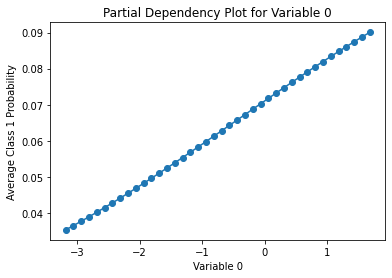

In [12]:
# Assuming X_tab_test is a numpy array
covariate_index = 0  # Replace with the actual index of the covariate/column you want to analyze

# Generate PDP for the specified covariate
values = np.linspace(X_tab_test[:, covariate_index].min(), X_tab_test[:, covariate_index].max(), num=40)
partial_dependency_values = []

for value in values:
    modified_data = X_tab_test.copy()
    modified_data[:, covariate_index] = value
    modified_input = (X_test, modified_data)  # Keep 3D images constant, modify only covariate
    modified_input = tuple(tf.convert_to_tensor(data) for data in modified_input)
    
    # Predict with the modified input
    prediction = predict_ontram(model_3d, data=[modified_input])['pdf'][:, 1]
    partial_dependency_values.append(prediction.mean())  # Assuming you want to visualize average predictions

# Plot the Partial Dependency Plot
plt.plot(values, partial_dependency_values, marker='o')
plt.title(f'Partial Dependency Plot for Variable {covariate_index}')
plt.xlabel(f'Variable {covariate_index}')
plt.ylabel('Average Class 1 Probability')
plt.show()


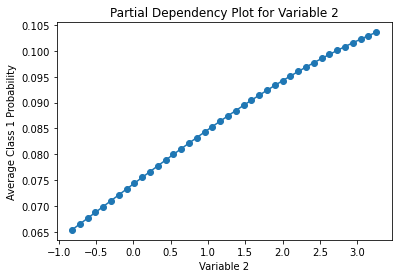

In [14]:
# Assuming X_tab_test is a numpy array
covariate_index = 2  # Replace with the actual index of the covariate/column you want to analyze

# Generate PDP for the specified covariate
values = np.linspace(X_tab_test[:, covariate_index].min(), X_tab_test[:, covariate_index].max(), num=40)
partial_dependency_values = []

for value in values:
    modified_data = X_tab_test.copy()
    modified_data[:, covariate_index] = value
    modified_input = (X_test, modified_data)  # Keep 3D images constant, modify only covariate
    modified_input = tuple(tf.convert_to_tensor(data) for data in modified_input)
    
    # Predict with the modified input
    prediction = predict_ontram(model_3d, data=[modified_input])['pdf'][:, 1]
    partial_dependency_values.append(prediction.mean())  # Assuming you want to visualize average predictions

# Plot the Partial Dependency Plot
plt.plot(values, partial_dependency_values, marker='o')
plt.title(f'Partial Dependency Plot for Variable {covariate_index}')
plt.xlabel(f'Variable {covariate_index}')
plt.ylabel('Average Class 1 Probability')
plt.show()


In [77]:
patient_index = 0
covariate_index = 0
num_values = 20
repeated_Y_test = np.tile(to_categorical(y_test)[patient_index], (num_values, 1))
patient_ex_img = np.expand_dims(X_test[patient_index], axis = -1)
expanded_array = np.tile(patient_ex_img, (num_values, 1, 1, 1, 1))
values = np.linspace(X_tab_test[:, covariate_index].min(), X_tab_test[:, covariate_index].max(), num=num_values)
value = values[0]
repeated_arr = np.tile(X_tab_test[patient_index, :], (num_values, 1))
for i in range(len(values)):
    repeated_arr[i, covariate_index] = values[i]

In [81]:
test_data2 = tf.data.Dataset.from_tensor_slices((expanded_array, repeated_arr))
test_labels2 = tf.data.Dataset.from_tensor_slices((repeated_Y_test))
test_loader2 = tf.data.Dataset.zip((test_data2, test_labels2))
test_dataset_pred2 = (test_loader2.batch(num_values))

In [83]:
test_dataset_pred2

<BatchDataset shapes: (((None, 128, 128, 28, 1), (None, 13)), (None, 2)), types: ((tf.float32, tf.float64), tf.float32)>

In [87]:
probs = predict_ontram(model_3d, data = test_dataset_pred2)['pdf'][:,1]

In [88]:
values

array([-3.18334187, -2.927225  , -2.67110814, -2.41499128, -2.15887442,
       -1.90275755, -1.64664069, -1.39052383, -1.13440697, -0.87829011,
       -0.62217324, -0.36605638, -0.10993952,  0.14617734,  0.40229421,
        0.65841107,  0.91452793,  1.17064479,  1.42676166,  1.68287852])

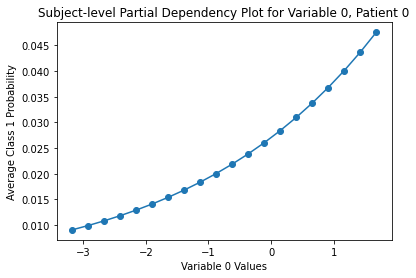

In [89]:
plt.plot(values, probs, marker='o')
plt.title(f'Subject-level Partial Dependency Plot for Variable {covariate_index}, Patient {patient_index}')
plt.xlabel(f'Variable {covariate_index} Values')
plt.ylabel('Average Class 1 Probability')
plt.show()

In [56]:
repeated_arr

array([[-0.68447194,  0.77017359, -0.49493262, -0.47096543,  2.37904752,
        -0.26359616, -0.11820485, -1.40037021, -0.44835758,  0.80633793,
        -0.55629662, -0.46097582, -0.47349193],
       [-0.68447194,  0.77017359, -0.49493262, -0.47096543,  2.37904752,
        -0.26359616, -0.11820485, -1.40037021, -0.44835758,  0.80633793,
        -0.55629662, -0.46097582, -0.47349193],
       [-0.68447194,  0.77017359, -0.49493262, -0.47096543,  2.37904752,
        -0.26359616, -0.11820485, -1.40037021, -0.44835758,  0.80633793,
        -0.55629662, -0.46097582, -0.47349193],
       [-0.68447194,  0.77017359, -0.49493262, -0.47096543,  2.37904752,
        -0.26359616, -0.11820485, -1.40037021, -0.44835758,  0.80633793,
        -0.55629662, -0.46097582, -0.47349193],
       [-0.68447194,  0.77017359, -0.49493262, -0.47096543,  2.37904752,
        -0.26359616, -0.11820485, -1.40037021, -0.44835758,  0.80633793,
        -0.55629662, -0.46097582, -0.47349193],
       [-0.68447194,  0.770173

In [52]:
patient_data.shape

(13,)

In [53]:
X_tab_test.shape

(41, 13)

In [39]:
patient_data = X_tab_test[patient_index, :].copy()
values = np.linspace(X_tab_test[:, covariate_index].min(), X_tab_test[:, covariate_index].max(), num=num_values)
partial_dependency_values = []
value = values[0]
modified_data = patient_data.copy()
modified_data[covariate_index] = value
modified_input = (X_test[patient_index], modified_data)
modified_input = tuple(tf.convert_to_tensor(data) for data in modified_input)

In [ ]:
patient_ex_img = np.expand_dims(X_test[0], axis = -1)
expanded_array = np.tile(patient_ex_img, (41, 1, 1, 1, 1))

In [43]:
modified_input = (X_test[patient_index], modified_data)

ValueError: Data cardinality is ambiguous:
  x sizes: 128, 13
Please provide data which shares the same first dimension.

In [37]:
modified_data

array([-0.68447194,  0.77017359, -0.49493262, -0.47096543,  2.37904752,
       -0.26359616, -0.11820485, -1.40037021, -0.44835758,  0.80633793,
       -0.55629662, -0.46097582, -0.47349193])

In [24]:
        modified_data = X_tab_test.copy()
        modified_data[:, covariate_index] = value
        modified_input = (X_test, modified_data)  # Keep 3D images constant, modify only covariate for the entire dataset
        modified_input = tuple(tf.convert_to_tensor(data) for data in modified_input)

        # Predict with the modified input
        prediction = predict_ontram(model_3d, data=[modified_input])['pdf'][:, 1]
        partial_dependency_values.append(prediction.mean())  # Assuming you want to visualize average predictions

array([-0.68447194,  0.77017359, -0.49493262, -0.47096543,  2.37904752,
       -0.26359616, -0.11820485, -1.40037021, -0.44835758,  0.80633793,
       -0.55629662, -0.46097582, -0.47349193])

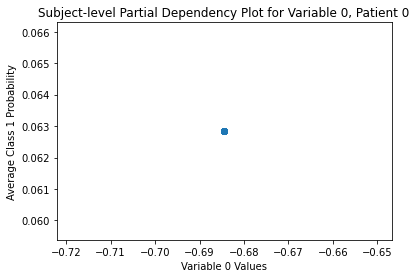

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming X_tab_test is a numpy array and each row corresponds to a patient
# covariate_index represents the index of the covariate/column you want to analyze
# patient_index represents the index of the patient you want to analyze

def generate_subject_pdp(X_tab_test, X_test, model_3d, covariate_index, patient_index, num_values=20):
    patient_data = X_tab_test[patient_index, :].copy()

    values = np.linspace(patient_data[covariate_index].min(), patient_data[covariate_index].max(), num=num_values)
    partial_dependency_values = []

    for value in values:
        modified_data = X_tab_test.copy()
        modified_data[:, covariate_index] = value
        modified_input = (X_test, modified_data)  # Keep 3D images constant, modify only covariate for the entire dataset
        modified_input = tuple(tf.convert_to_tensor(data) for data in modified_input)

        # Predict with the modified input
        prediction = predict_ontram(model_3d, data=[modified_input])['pdf'][:, 1]
        partial_dependency_values.append(prediction.mean())  # Assuming you want to visualize average predictions

    # Plot the Partial Dependency Plot
    plt.plot(values, partial_dependency_values, marker='o')
    plt.title(f'Subject-level Partial Dependency Plot for Variable {covariate_index}, Patient {patient_index}')
    plt.xlabel(f'Variable {covariate_index} Values')
    plt.ylabel('Average Class 1 Probability')
    plt.show()

# Example usage:
covariate_index = 0  # Replace with the actual index of the covariate/column you want to analyze
patient_index = 0  # Replace with the index of the patient you want to analyze
generate_subject_pdp(X_tab_test, X_test, model_3d, covariate_index, patient_index)


# Gravy

In [22]:
model_nr = 0
which_split = 0
(X_train, X_valid, X_test),(X_tab_train, X_tab_valid, X_tab_test), (y_train, y_valid, y_test) = rdat.split_data_tabular(id_tab, X, which_split)


In [27]:
values_age_new = np.linspace(X_tab_test[:, 0].min(), X_tab_test[:, 0].max(), 50)

In [33]:
patient_ex_img = np.expand_dims(X_test[0], axis = -1)
expanded_array = np.tile(patient_ex_img, (41, 1, 1, 1, 1))

In [36]:
expanded_array = np.tile(patient_ex_img, (41, 1, 1, 1, 1))

In [38]:
expanded_array.shape

(41, 128, 128, 28, 1)

### ACHTUNG

In [12]:
model_name = ("/tf/notebooks/schnemau/xAI_stroke_3d/weights/10Fold_CIBLSX/3d_cnn_binary_model_split" + "CIB_LSX" + str(which_split) + 
                    "_normalized_avg_layer_paper_model_" + last_activation + 
                    "_activation_" + str(model_version) + "_" + str(model_nr) + ".h5")        

model_3d.load_weights(model_name)

In [20]:
X_tab_test = np.random.rand(41, 13)
X_tab_test

array([[0.29154388, 0.93807289, 0.98692461, 0.60425937, 0.29351029,
        0.04673549, 0.26950148, 0.39705769, 0.82437647, 0.47038949,
        0.2439176 , 0.01739093, 0.52756264],
       [0.42188826, 0.45844573, 0.51647241, 0.59314651, 0.51370193,
        0.12447081, 0.55377081, 0.37352785, 0.94269396, 0.35900713,
        0.39198205, 0.8024987 , 0.74180458],
       [0.7494283 , 0.40082219, 0.57249118, 0.04178301, 0.82591598,
        0.8725831 , 0.17198178, 0.71536635, 0.98607208, 0.94875239,
        0.52042769, 0.05641996, 0.51703179],
       [0.61819591, 0.31541041, 0.80642586, 0.63397984, 0.78183389,
        0.84920517, 0.16269982, 0.33029077, 0.27188203, 0.88492569,
        0.75635698, 0.87927578, 0.95042946],
       [0.40382019, 0.64313946, 0.3903146 , 0.33701563, 0.05675714,
        0.65103505, 0.34133459, 0.89052125, 0.0848905 , 0.75941045,
        0.4501234 , 0.08821854, 0.8596338 ],
       [0.4362053 , 0.27337521, 0.57503648, 0.60731705, 0.99751292,
        0.11990038, 0.04491

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming X_tab_test is a pandas DataFrame
covariate_of_interest = 'age'  # Replace with the actual covariate name

# Generate PDP for the specified covariate
values = np.linspace(X_tab_test[covariate_of_interest].min(), X_tab_test[covariate_of_interest].max(), num=20)
partial_dependency_values = []

for value in values:
    modified_data = X_tab_test.copy()
    modified_data[covariate_of_interest] = value
    modified_input = (X_test, modified_data)  # Keep 3D images constant, modify only covariate
    modified_input = tuple(tf.convert_to_tensor(data) for data in modified_input)
    
    # Predict with the modified input
    prediction = predict_ontram(model_3d, data=[modified_input])['pdf'][:, 1].numpy()
    partial_dependency_values.append(prediction.mean())  # Assuming you want to visualize average predictions

# Plot the Partial Dependency Plot
plt.plot(values, partial_dependency_values, marker='o')
plt.title(f'Partial Dependency Plot for {covariate_of_interest}')
plt.xlabel(covariate_of_interest)
plt.ylabel('Average Class 1 Probability')
plt.show()
